In [14]:
import os
import glob
import configparser

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

In [68]:
# load world countries shapefile
file = "ne_10m_admin_0_countries"
countries = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "natural-earth\\%s\\%s.shp" %(file, file)))
countries.head()

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 country,0,2,Indonesia,IDN,0,2,Sovereign country,1,Indonesia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,0,3,Malaysia,MYS,0,2,Sovereign country,1,Malaysia,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,1,Chile,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,1,Bolivia,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,1,Peru,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [155]:
#get Press Freedom Index data

#read in all years and combine
files = glob.glob(os.path.join(project_root, "PressFreedomIndex") + "/*.csv")

raw = []

for filename in files:
    df = pd.read_csv(filename, sep=';', decimal=",")
    raw.append(df)

data = pd.concat(raw, axis=0, ignore_index=True)

data.head()

,Year (N),ISO,Rank N,Score N,Score N without the exactions,Score N with the exactions,Score exactions,Rank N-1,Score N-1,Rank evolution,...,Social Context,Rank_Soc,Safety,Rank_Saf,Country_EN,Country_FR,Country_ES,Country_AR,Country_FA,"Rank evolution,,,,,,"
0,2003,FIN,1.0,0.5,NaN,NaN,NaN,1.0,0.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,ISL,1.0,0.5,NaN,NaN,NaN,2.0,0.5,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,NOR,1.0,0.5,NaN,NaN,NaN,3.0,0.5,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,NLD,1.0,0.5,NaN,NaN,NaN,4.0,0.5,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,DNK,5.0,1.0,NaN,NaN,NaN,10.0,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[85 ; 100 points] : Good situation (green)

[75 ; 85 points] : Satisfactory situation (yellow)

[65 ; 75 points] : Problematic situation (light orange)

[45 ; 65 points] : Difficult situation (dark orange)

[0 ; 45 points] : Very serious situation (dark red)


In [156]:
## clean country names
data["ISO_clean"] = data["ISO"]
data["ISO_clean"] = data["ISO_clean"].str.replace("USA2", "USA")

# score classification
classification = []

for score in data["Score N"]:
    if score >= 85:
        classification.append(5)
    elif (score < 85) & (score >=75):
        classification.append(4)
    elif (score < 75) & (score >=65):
        classification.append(3)
    elif (score < 65) & (score >=45):
        classification.append(2)
    elif (score < 45) & (score >=0):
        classification.append(1)
    else:
        classification.append(np.nan)

data["score_class"] = classification

score_class_labels = {5: "Good", 4: "Satisfactory", 3: "Problematic", 2: "Difficult", 1: "Very serious"}
data["score_class_labels"] = data["score_class"].map(score_class_labels)

## Simple plot

In [217]:
#for colorbar
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

minColor = 0
maxColor = 0.85
new_cmap = truncate_colormap(plt.get_cmap("viridis"), minColor, maxColor)
new_cmap

In [212]:
colors = { "Good": "#9BD93C", "Satisfactory": "#2CB17E", "Problematic": "#277F8E",
          "Difficult": "#3F4788", "Very serious": "#440154"}

In [166]:
#dataframe to plot
df1 = countries[['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3', 'ADM0_DIF', 'LEVEL', 'TYPE', 'ADMIN',
           'ADM0_A3',"ISO_A3", "geometry"]]
df2 = data[['Year (N)', 'ISO','ISO_clean', 'Rank N', 'Score N',"score_class","score_class_labels", 
           'Score N without the exactions',
       'Score N with the exactions', 'Score exactions', 'Rank N-1','Score N-1', 'Rank evolution', 'EN_country']]
gdf = pd.merge(df1,df2, left_on="ADM0_A3", right_on="ISO_clean", how="inner")
gdf = gdf.to_crs(900913)

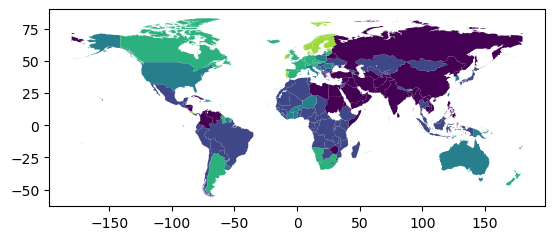

In [209]:
#style single map/image
gdf[gdf["Year (N)"]==2022].plot(column="score_class", cmap=new_cmap)
plt.show()

score_class_labels,Difficult,Good,Problematic,Satisfactory,Very serious,Ok,Bad
Year (N),,,,,,,
2013.0,36,25,67,26,20,51,56
2014.0,44,25,60,27,19,52,63
2015.0,44,21,60,30,20,51,64
2016.0,47,16,58,36,18,52,65
2017.0,49,16,57,32,21,48,70
2018.0,46,17,61,29,22,46,68
2019.0,50,15,63,28,19,43,69
2020.0,45,14,61,32,23,46,68
2021.0,50,12,57,35,21,47,71


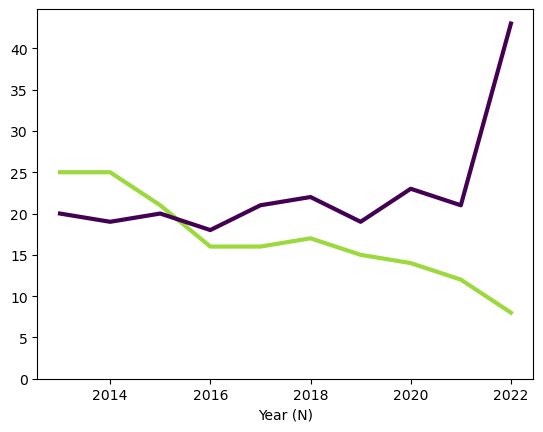

In [219]:
pivot = gdf[gdf["Year (N)"].isin(years)].groupby(["Year (N)", "score_class_labels"])["ISO"].count().unstack()
pivot["Ok"] = pivot[["Good", "Satisfactory"]].sum(axis=1)
pivot["Bad"] = pivot[["Difficult", "Very serious"]].sum(axis=1)

for column in ["Good", "Very serious"]:
    pivot[column].plot(color=colors[column], linewidth=3)

plt.gca().set_ylim(ymin=0)
pivot

2013


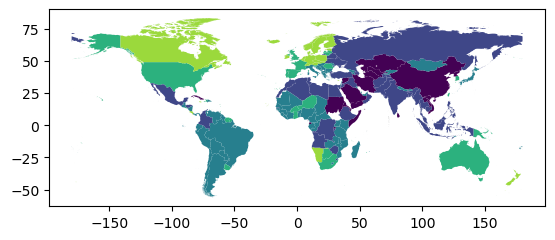

2014


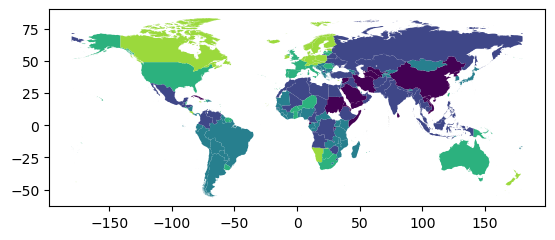

2015


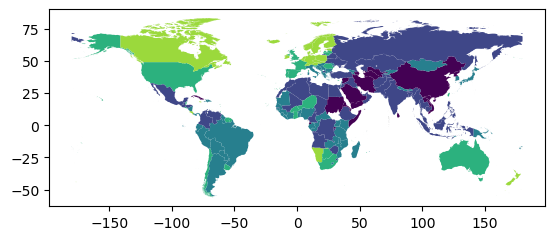

2016


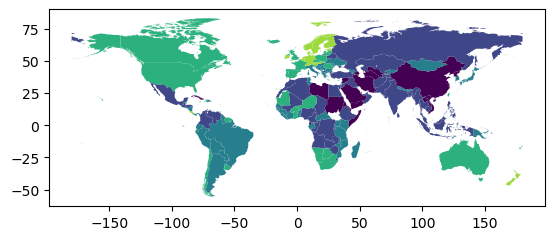

2017


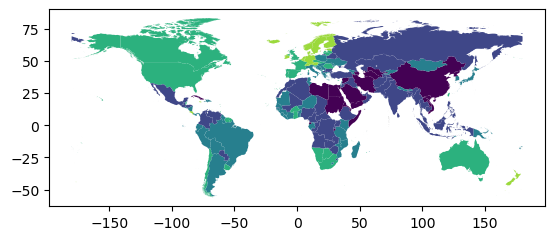

2018


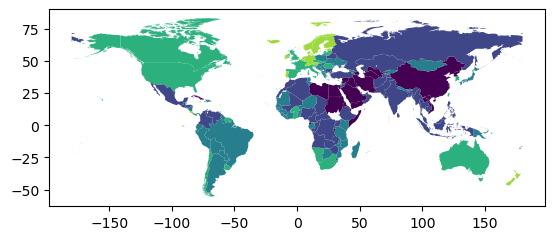

2019


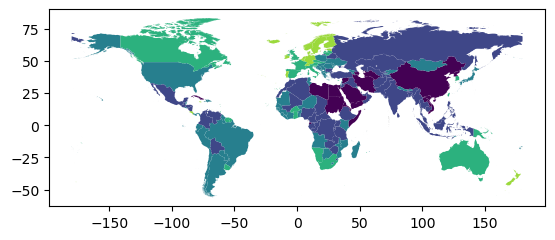

2020


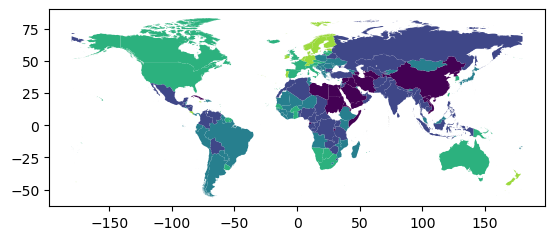

2021


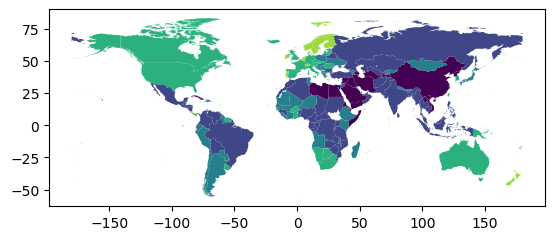

2022


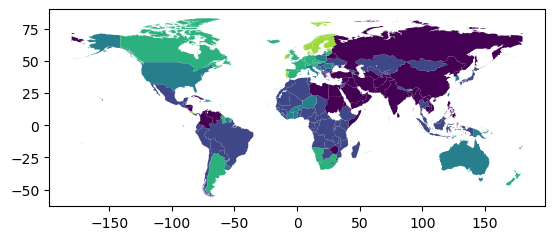

In [210]:
## loop through years

years = [2013,2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
for year in years:
    print(year)
    gdf[gdf["Year (N)"]==year].plot(column="score_class", cmap=new_cmap)
    plt.show()

In [ ]:
# create gif


# Gif

In [ ]:
## create gif
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

    
#Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)